In [1]:
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2021-07-07 01:43:34.417137: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-07 01:43:34.417167: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

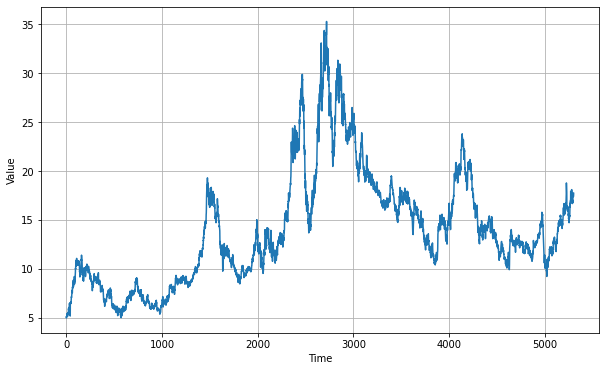

In [3]:
coffee_time_step = []
coffee_temps = []

with open('dataset/commodities/sugar.csv') as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    next(reader)
    step = 0
    for row in reader:
        price_close = row[5]
        if price_close == "null":
            continue
        coffee_temps.append(float(price_close))
        coffee_time_step.append(step)
        step = step + 1

coffee_series = np.array(coffee_temps)
coffee_time = np.array(coffee_time_step)
plt.figure(figsize=(10, 6))
plot_series(coffee_time, coffee_series)

In [4]:
split_time_coffee = 2500
time_train_coffee = coffee_time[:split_time_coffee]
x_train_coffee = coffee_series[:split_time_coffee]
time_valid_coffee = coffee_time[split_time_coffee:]
x_valid_coffee = coffee_series[split_time_coffee:]

window_size_coffee = 30
batch_size_coffee = 32
shuffle_buffer_size_coffee = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train_coffee, window_size, batch_size, shuffle_buffer_size_coffee)
print(train_set)
print(x_train_coffee.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu", input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

2021-07-07 01:43:35.728281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-07 01:43:35.728314: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-07 01:43:35.728340: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alshum-go): /proc/driver/nvidia/version does not exist
2021-07-07 01:43:35.728542: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


/home/alshum/Documents/project/gemastik_ml/venv/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-07-07 01:43:36.273605: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-07 01:43:36.294183: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1999965000 Hz


Epoch 1/100
10/10 [==============================] - 4s 144ms/step - loss: 29.2684 - mae: 29.7656
Epoch 2/100
10/10 [==============================] - 1s 138ms/step - loss: 28.4011 - mae: 28.8969
Epoch 3/100
10/10 [==============================] - 2s 144ms/step - loss: 27.0559 - mae: 27.5505
Epoch 4/100
10/10 [==============================] - 2s 152ms/step - loss: 25.3860 - mae: 25.8818
Epoch 5/100
10/10 [==============================] - 2s 160ms/step - loss: 23.4686 - mae: 23.9641
Epoch 6/100
10/10 [==============================] - 1s 135ms/step - loss: 21.3329 - mae: 21.8289
Epoch 7/100
10/10 [==============================] - 1s 138ms/step - loss: 18.8837 - mae: 19.3823
Epoch 8/100
10/10 [==============================] - 2s 176ms/step - loss: 15.8981 - mae: 16.3962
Epoch 9/100
10/10 [==============================] - 2s 142ms/step - loss: 12.3359 - mae: 12.8309
Epoch 10/100
10/10 [==============================] - 2s 140ms/step - loss: 8.5166 - mae: 9.0029
Epoch 11/100
10/10 [=

10/10 [==============================] - 2s 196ms/step - loss: 20.1734 - mae: 20.6700
Epoch 86/100
10/10 [==============================] - 2s 162ms/step - loss: 27.5981 - mae: 28.0980
Epoch 87/100
10/10 [==============================] - 2s 165ms/step - loss: 27.7801 - mae: 28.2781
Epoch 88/100
10/10 [==============================] - 2s 141ms/step - loss: 11.8860 - mae: 12.3719
Epoch 89/100
10/10 [==============================] - 2s 150ms/step - loss: 10.2210 - mae: 10.7164
Epoch 90/100
10/10 [==============================] - 2s 147ms/step - loss: 23.7723 - mae: 24.2716
Epoch 91/100
10/10 [==============================] - 2s 150ms/step - loss: 25.6549 - mae: 26.1540
Epoch 92/100
10/10 [==============================] - 2s 158ms/step - loss: 29.2367 - mae: 29.7367
Epoch 93/100
10/10 [==============================] - 2s 162ms/step - loss: 32.3560 - mae: 32.8560
Epoch 94/100
10/10 [==============================] - 2s 148ms/step - loss: 37.3771 - mae: 37.8771
Epoch 95/100
10/10 [===

(1e-08, 0.0001, 0.0, 60.0)

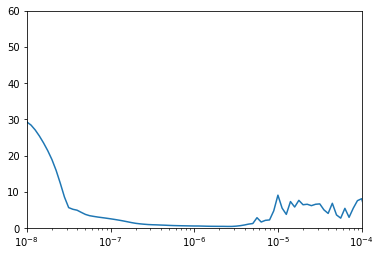

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train_coffee, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size_coffee)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 4s 76ms/step - loss: 13.0098 - mae: 13.4969
Epoch 2/150
25/25 [==============================] - 2s 72ms/step - loss: 2.7162 - mae: 3.1947
Epoch 3/150
25/25 [==============================] - 2s 79ms/step - loss: 1.0315 - mae: 1.4515
Epoch 4/150
25/25 [==============================] - 2s 71ms/step - loss: 1.8574 - mae: 2.3116
Epoch 5/150
25/25 [==============================] - 2s 69ms/step - loss: 2.7364 - mae: 3.2119
Epoch 6/150
25/25 [==============================] - 2s 67ms/step - loss: 0.5171 - mae: 0.9002
Epoch 7/150
25/25 [==============================] - 2s 65ms/step - loss: 0.5479 - mae: 0.9359
Epoch 8/150
25/25 [==============================] - 2s 65ms/step - loss: 0.4029 - mae: 0.7502
Epoch 9/150
25/25 [==============================] - 2s 67ms/step - loss: 0.4942 - mae: 0.9007
Epoch 10/150
25/25 [==============================] - 2s 72ms/step - loss: 0.4148 - mae: 0.7858
Epoch 11/150
25/25 [===========================

25/25 [==============================] - 2s 71ms/step - loss: 0.0782 - mae: 0.2830
Epoch 87/150
25/25 [==============================] - 2s 75ms/step - loss: 0.0961 - mae: 0.3233
Epoch 88/150
25/25 [==============================] - 2s 64ms/step - loss: 0.0804 - mae: 0.2913
Epoch 89/150
25/25 [==============================] - 2s 69ms/step - loss: 0.1065 - mae: 0.3458
Epoch 90/150
25/25 [==============================] - 2s 64ms/step - loss: 0.0864 - mae: 0.3051
Epoch 91/150
25/25 [==============================] - 2s 64ms/step - loss: 0.1210 - mae: 0.3817
Epoch 92/150
25/25 [==============================] - 2s 65ms/step - loss: 0.0899 - mae: 0.3201
Epoch 93/150
25/25 [==============================] - 2s 66ms/step - loss: 0.0745 - mae: 0.2736
Epoch 94/150
25/25 [==============================] - 2s 70ms/step - loss: 0.0703 - mae: 0.2621
Epoch 95/150
25/25 [==============================] - 2s 66ms/step - loss: 0.0953 - mae: 0.3166
Epoch 96/150
25/25 [==============================] -

In [10]:
rnn_forecast = model_forecast(model, coffee_series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time_coffee - window_size:-1, -1, 0]

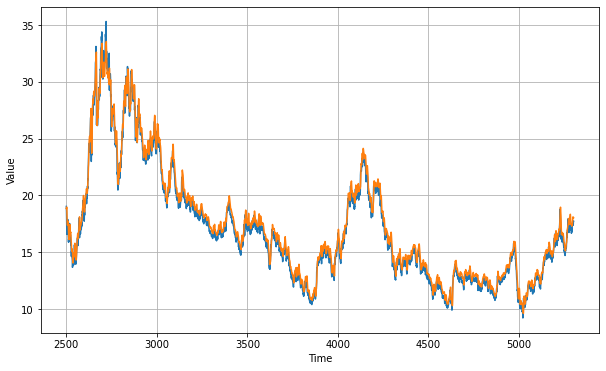

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid_coffee, x_valid_coffee)
plot_series(time_valid_coffee, rnn_forecast)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid_coffee, rnn_forecast).numpy()

0.48151165

In [13]:
days_future = 50
temp = len(x_valid_coffee)-days_future
temp = x_valid_coffee[temp:]

mantap_mania = []

for i in range(days_future):
    rnn_forecast = model_forecast(model, temp[..., np.newaxis], len(temp))
    waw = rnn_forecast[0][-1][0]
    mantap_mania.append(waw)
    
    temp = np.delete(temp, 0)
    temp = np.append(temp, waw)

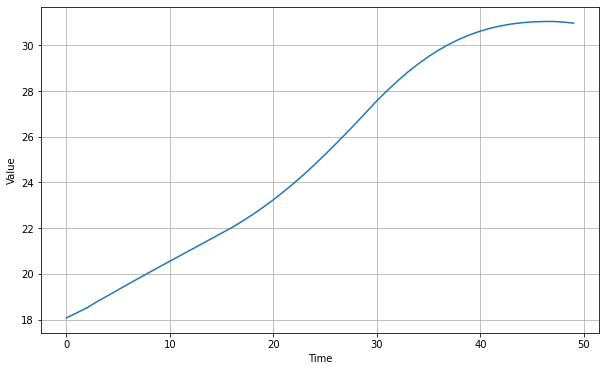

In [14]:
plt.figure(figsize=(10, 6))
coffee_range_zero = range(len(mantap_mania))
plot_series(coffee_range_zero, mantap_mania)

In [15]:
print(mantap_mania)

[18.07269, 18.295864, 18.518528, 18.797857, 19.044453, 19.303507, 19.55907, 19.80986, 20.061466, 20.309044, 20.555077, 20.800056, 21.047037, 21.29117, 21.536625, 21.782526, 22.028456, 22.303867, 22.59688, 22.907719, 23.242298, 23.598783, 23.974709, 24.372387, 24.788773, 25.222223, 25.671509, 26.133612, 26.606651, 27.087263, 27.572271, 28.017754, 28.438631, 28.830667, 29.185612, 29.509193, 29.796024, 30.050125, 30.271852, 30.459522, 30.618467, 30.747902, 30.850962, 30.929115, 30.983374, 31.019846, 31.035992, 31.0393, 31.011808, 30.96439]


In [16]:
model.save('sugar_model.h5')

In [17]:
ashiap_model = tf.keras.models.load_model('sugar_model.h5')
ashiap_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [18]:
def cok(model):
    days_future = 50
    temp = len(x_valid_coffee)-days_future
    temp = x_valid_coffee[temp:]
    mantap_mania = []
    for i in range(days_future):
        rnn_forecast = model_forecast(model, temp[..., np.newaxis], len(temp))
        waw = rnn_forecast[0][-1][0]
        mantap_mania.append(waw)
        temp = np.delete(temp, 0)
        temp = np.append(temp, waw)
    
    print(type(mantap_mania))
    plt.figure(figsize=(10, 6))
    coffee_range_zero = range(len(mantap_mania))
    plot_series(coffee_range_zero, mantap_mania)

<class 'list'>


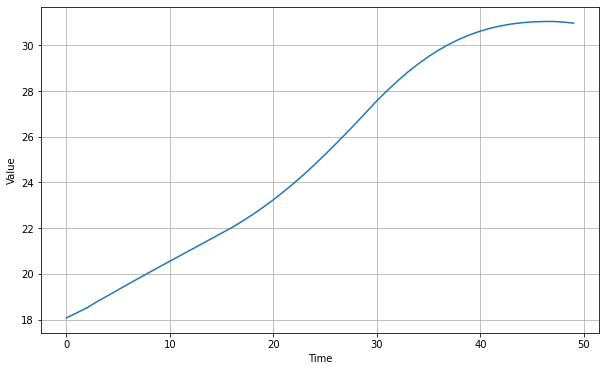

In [19]:
cok(ashiap_model)